In [17]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedUMNNAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [55]:
import numpy as np
from matplotlib.colors import LogNorm

In [45]:
train_data_saved = np.load("train_data_saved.npy")

In [46]:
train_data_saved

array([[ 0.21528083,  0.28760347,  0.01815071],
       [ 0.20627484,  0.11777371, -0.00643062],
       [-0.19949207, -0.03904223, -0.00501743],
       ...,
       [-0.8632761 , -0.26469624,  0.06155147],
       [ 0.43375329,  0.45911132,  0.01825673],
       [ 0.06021562,  0.37110911,  0.13233738]])

In [50]:
train_data_saved[:,1:]

array([[ 0.28760347,  0.01815071],
       [ 0.11777371, -0.00643062],
       [-0.03904223, -0.00501743],
       ...,
       [-0.26469624,  0.06155147],
       [ 0.45911132,  0.01825673],
       [ 0.37110911,  0.13233738]])

In [40]:
def make_examples(nsamples):
    #x = np.random.uniform(low=-1., high=2.0, size= nsamples)
    x = np.random.exponential(scale=0.01, size= nsamples)
    #x = x_GS0x7[:nsamples]
    y = np.random.uniform(low=0.25, high=.5, size= nsamples)
    return np.vstack((x,y)).T, np.zeros(nsamples)
    

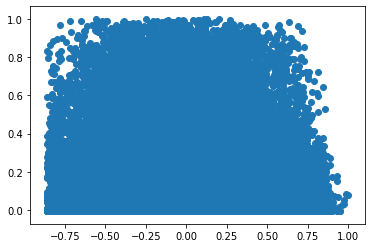

In [51]:
x, y = make_examples(500) #datasets.make_moons(128, noise=.1)
#x = train_data_saved[:,1:]
plt.scatter(x[:, 0], x[:, 1]);

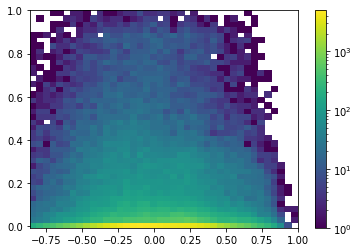

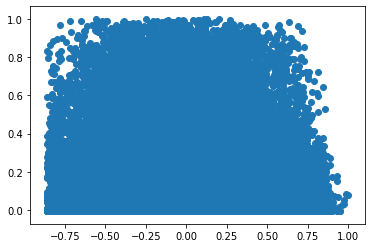

In [57]:
x_val = train_data_saved[:,1:]

fig, ax = plt.subplots()
h = ax.hist2d(x_val[:, 0], x_val[:, 1], bins=40, norm=LogNorm())
fig.colorbar(h[3], ax=ax)

plt.show()

plt.scatter(x_val[:, 0], x_val[:, 1])

plt.show()


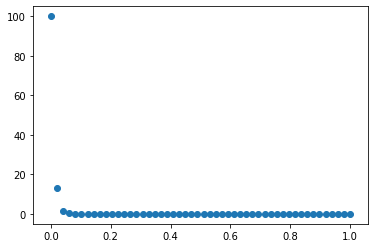

In [28]:
beta = 0.01
x = np.linspace(0, 1)
y = 1/beta* np.exp(-x/beta)
plt.scatter(x,y)
plt.show()

In [154]:
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    #transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
    #                                                      hidden_features=4))
    transforms.append(MaskedUMNNAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())


In [139]:
class DatasetNumpy:
    def __init__(self, arr):
        self.arr = arr
        self.size = arr.shape[0]
        self.nsampled = 0
        
    def get_data(self, batch_size):
        if (batch_size+ self.nsampled) >= self.size:
            res = self.arr[self.nsampled:, :].copy()
            self.nsampled = 0
            np.random.shuffle(self.arr)
            return res
        else:
            res = self.arr[self.nsampled:(self.nsampled+batch_size), :]
            self.nsampled += batch_size
            return res
        
    def get_array(self):
        return self.arr

In [119]:
def make_line_examples():
    #x = np.random.uniform(low=-1., high=2.0, size= nsamples)
    x = np.array(range(10))
    #x = x_GS0x7[:nsamples]
    y = np.array(range(10))
    return np.vstack((x,y)).T

In [150]:
ds = DatasetNumpy(make_line_examples())
ds.get_data(8)


(135373, 2)

Number of data points :  (135373, 2)


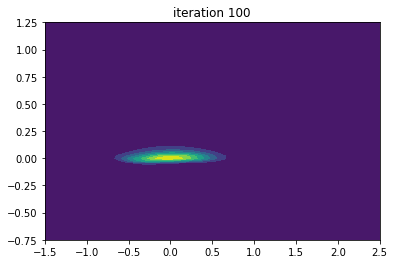

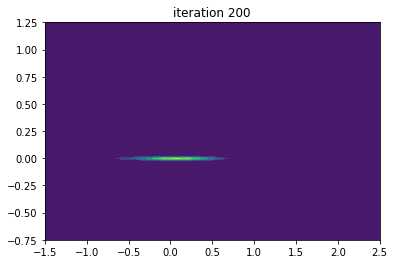

yes


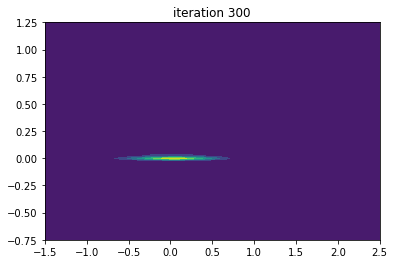

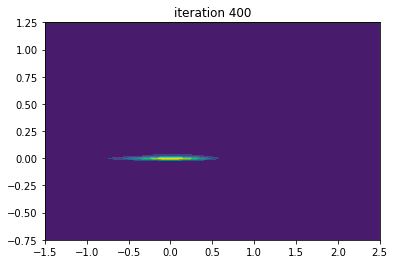

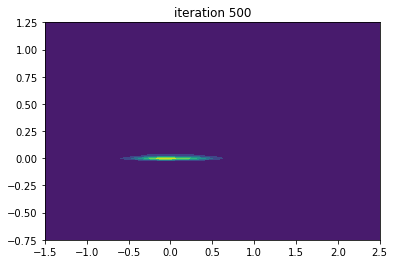

yes


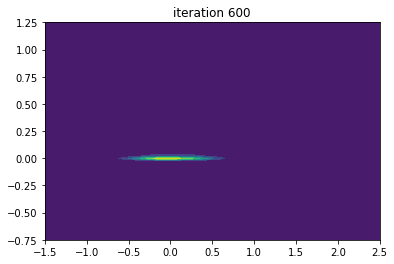

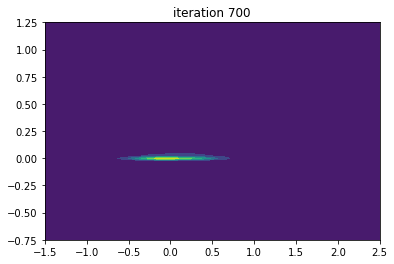

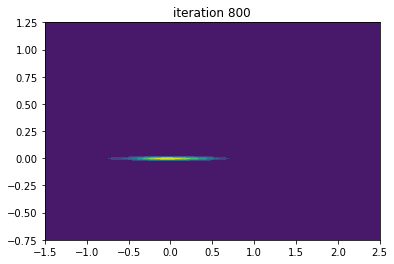

yes


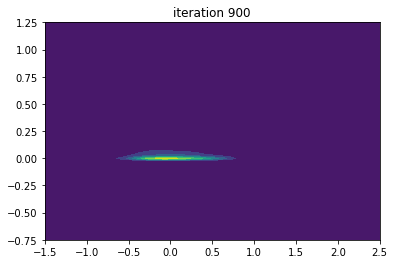

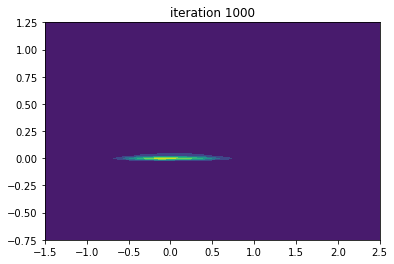

yes


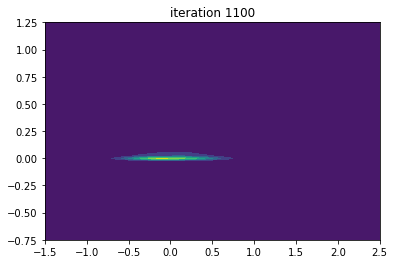

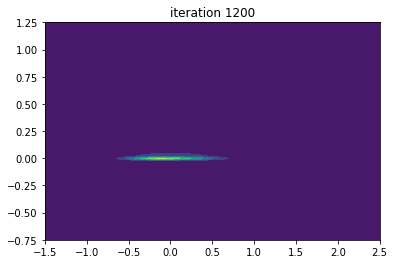

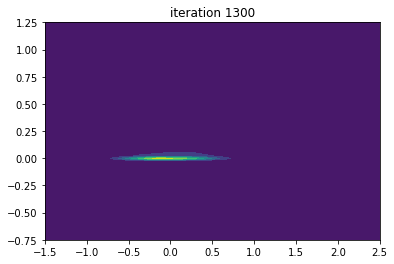

yes


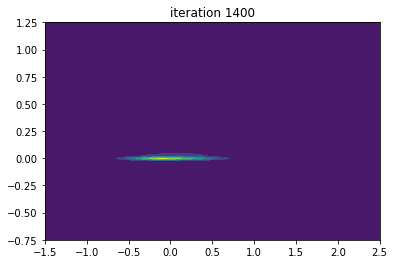

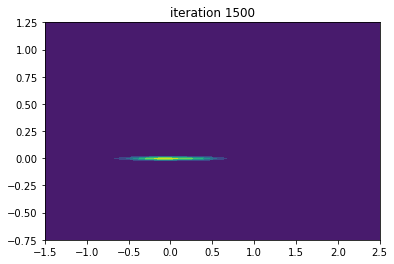

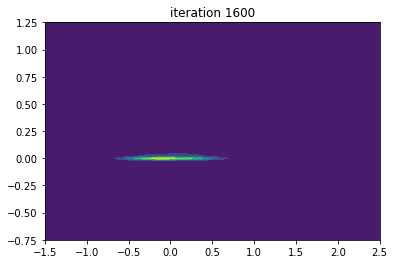

yes


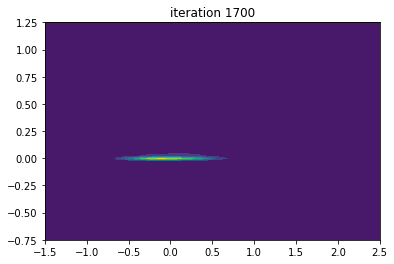

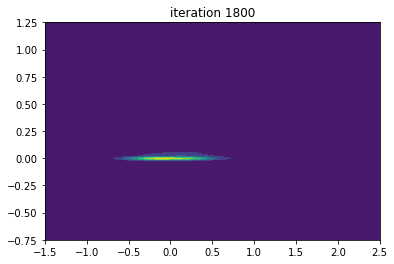

yes


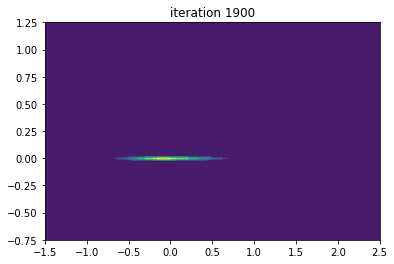

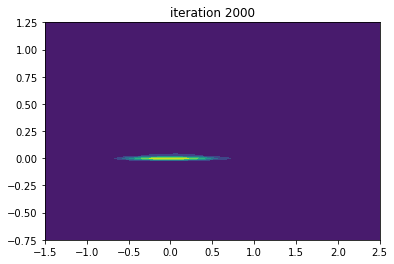

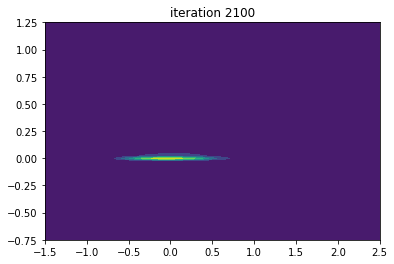

yes


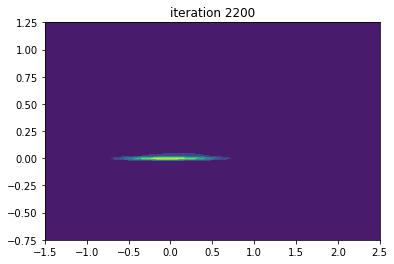

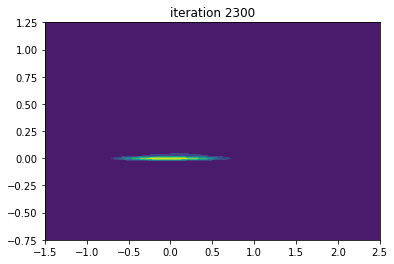

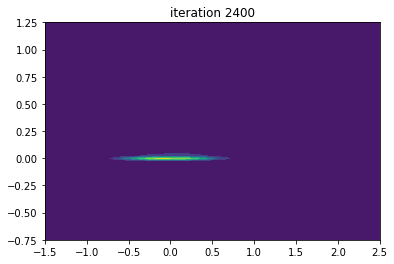

yes


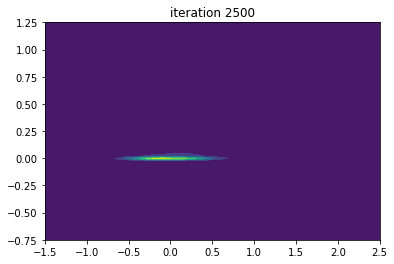

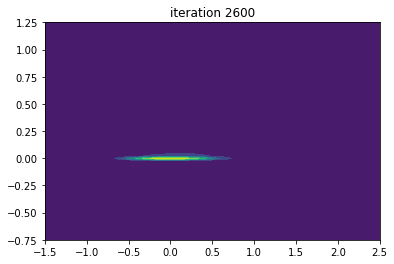

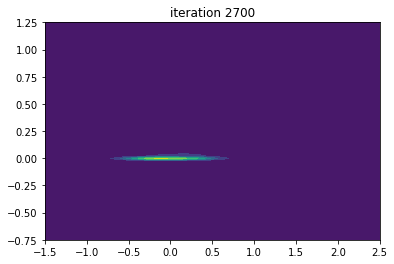

yes


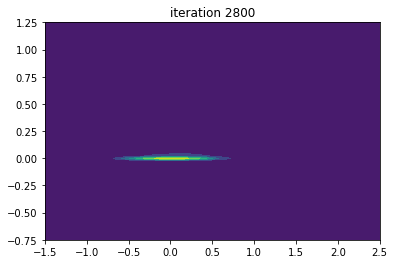

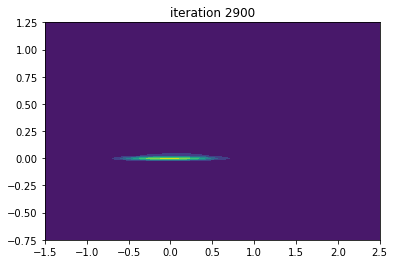

yes


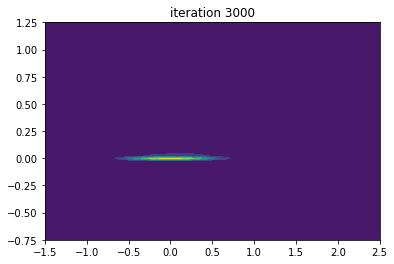

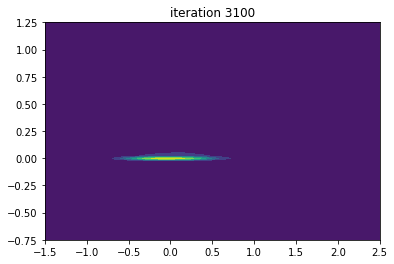

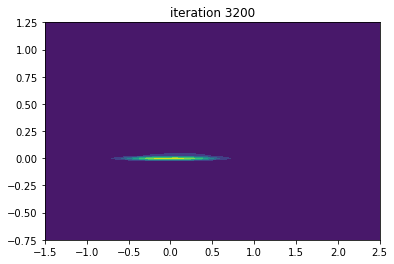

yes


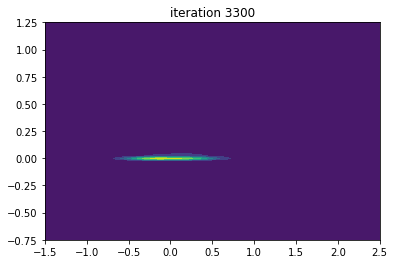

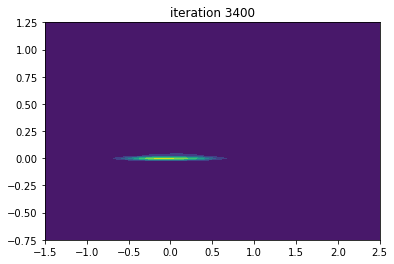

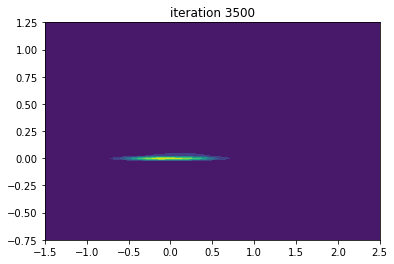

yes


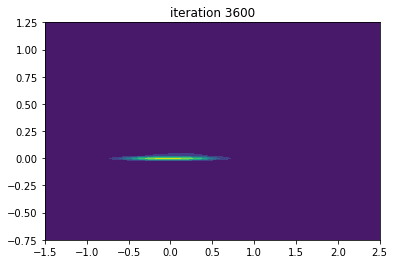

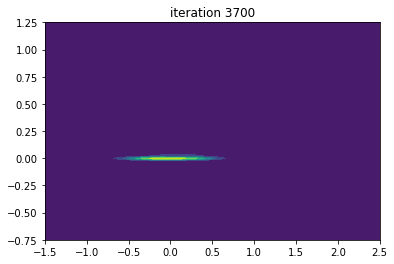

yes


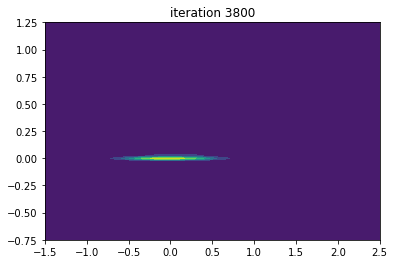

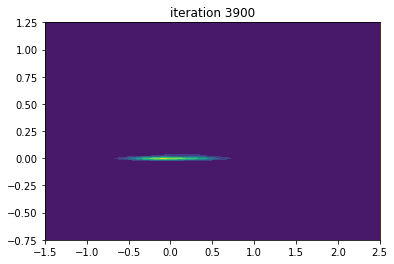

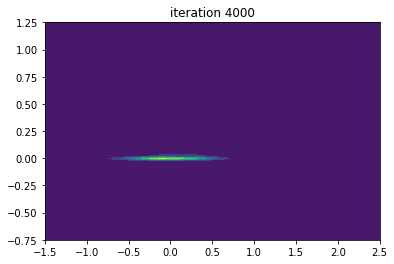

yes


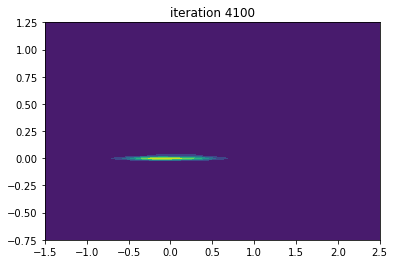

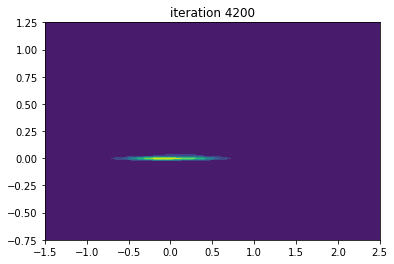

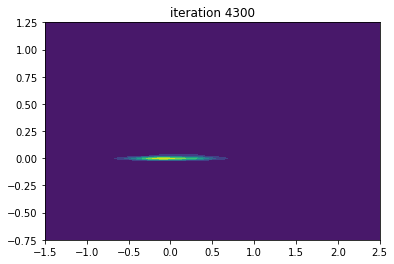

yes


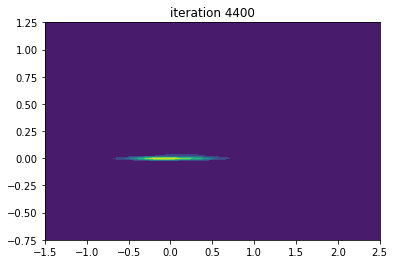

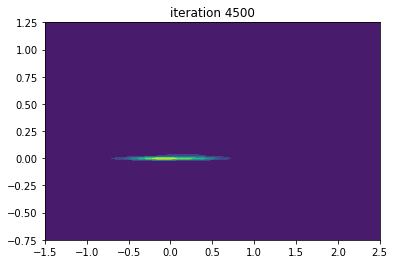

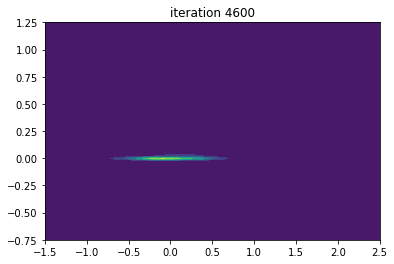

yes


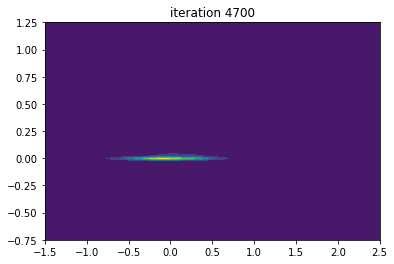

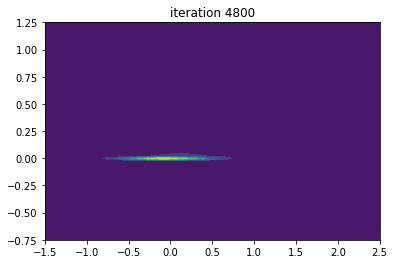

yes


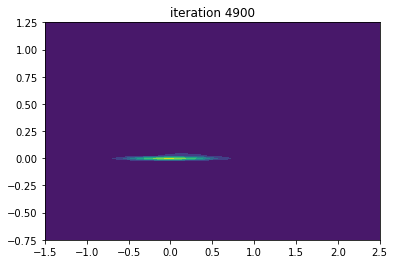

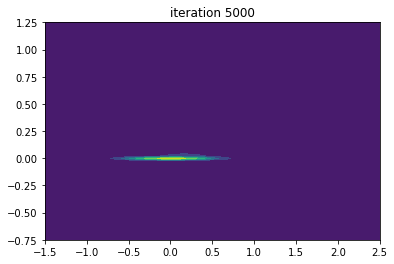

In [157]:
ds = DatasetNumpy(train_data_saved[:,1:])
print("Number of data points : ", train_data_saved[:,1:].shape)

num_iter = 5000
for i in range(num_iter):
    #x, y = make_examples(500) #datasets.make_moons(500, noise=.1)
    #x = train_data_saved[:,1:]
    x = ds.get_data(500)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    #if (i + 1) % 500 == 0:
    if (i + 1) % 100 == 0:
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()